In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from feature_engine.outliers import Winsorizer


In [2]:
import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv(r'C:\Users\Dell\gitproject\Customer Segmentation using RFM Clustering\Online_Retail.csv')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/2011 12:50,4.95,12680.0,France


## Data Preparation

In [5]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


- 

In [6]:
df.loc[(df.UnitPrice<0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,8/12/2011 14:51,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,8/12/2011 14:52,-11062.06,NaN,United Kingdom


In [7]:
df.loc[(df.Quantity<0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315.0,United Kingdom



- <b>The min and max value for Quantity is 80995,this could represent cancelled or returned orders.</b>
- <b>The UnitPrice also have few negative values which is uncommon,these transactions could represent cancelled orders by customers or bad-debt incurred by the business.</b>
- <b>Bad debt adjustments will be dropped from the dataset as these do not represent actual sales. </b>

In [8]:
df.describe(include='O')

,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,541909,541909,540455,541909,541909
unique,25900,4070,4223,23260,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,10/31/2011 14:41,United Kingdom
freq,1114,2313,2369,1114,495478


In [9]:
df.isnull().mean()*100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

<b>As customer clusters may vary by geography, we will restrict the data to only United Kingdom customers, which contains most of our customers historical data.</b>

In [10]:
df = df[df.Country == 'United Kingdom']

<b>Remove the negative values from Quantity and UnitPrice</b>

In [11]:
df = df[df.Quantity > 0]

In [12]:
df = df[df.UnitPrice > 0]

In [13]:
df = df[pd.notnull(df['CustomerID'])]

In [14]:
df.isnull().mean()

InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
UnitPrice      0.0
CustomerID     0.0
Country        0.0
dtype: float64

<b>Here we add a new column called TotalPrice.</b>

In [15]:
df['TotalPrice'] = df['Quantity']*df['UnitPrice']

<b>The last invoice date is 2011–12–09,we will use this date to calculate Recency.</b>

In [16]:
import datetime as dt
NOW = dt.date(2011,12,9) 

In [17]:
df['date'] = pd.DatetimeIndex(df.InvoiceDate).date

In [18]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,2010-12-01


## RFM Analysis

<b>Here, we will perform following operations:

- For Recency, Calculate the number of days between present date and date of last purchase each customer.
- For Frequency, Calculate the number of orders for each customer.
- For Monetary, Calculate sum of purchase price for each customer.</b>

In [19]:
df_recency = df.groupby(['CustomerID'],as_index=False)['date'].max()
df_recency.columns = ['CustomerID','Last_Purchase_Date']


In [20]:
df_recency['Recency'] = df_recency.Last_Purchase_Date.apply(lambda x:(NOW - x).days)

In [21]:
df_recency.head()

,CustomerID,Last_Purchase_Date,Recency
0,12346.0,2011-01-18,325
1,12747.0,2011-12-07,2
2,12748.0,2011-12-09,0
3,12749.0,2011-12-06,3
4,12820.0,2011-12-06,3


In [22]:
df_recency.drop(columns=['Last_Purchase_Date'],inplace=True)

In [23]:
FM_Table = df.groupby('CustomerID').agg({'InvoiceNo'   : lambda x:len(x),
                                         'TotalPrice'  : lambda x:x.sum()})

In [24]:
FM_Table.rename(columns = {'InvoiceNo' :'Frequency',
                           'TotalPrice':'Monetary_Value'},inplace= True) 

In [25]:
FM_Table.head()

,Frequency,Monetary_Value
CustomerID,,
12346.0,1,77183.60
12747.0,103,4196.01
12748.0,4595,33719.73
12749.0,199,4090.88
12820.0,59,942.34


In [26]:
RFM_Table = df_recency.merge(FM_Table,left_on='CustomerID',right_on='CustomerID')
RFM_Table.head()

,CustomerID,Recency,Frequency,Monetary_Value
0,12346.0,325,1,77183.60
1,12747.0,2,103,4196.01
2,12748.0,0,4595,33719.73
3,12749.0,3,199,4090.88
4,12820.0,3,59,942.34


In [27]:
df[df.CustomerID == 12346.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,date
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346.0,United Kingdom,77183.6,2011-01-18


In [28]:
(NOW - dt.date(2011,1,18)).days == 325

True

<b>Now we split the metrics into segments using quantiles.We assign a score from 1 to 4 to Recency, Frequency and Monetary. One is the best/highest value, and four is the lowest/worst value. A final RFM score is calculated simply by combining individual RFM score numbers.</b>

In [29]:
quantiles = RFM_Table.quantile(q=[0.25,0.50,0.75])
quantiles = quantiles.to_dict()

In [30]:
segmented_rfm = RFM_Table.copy()

In [31]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [32]:
segmented_rfm['R_quartile'] = segmented_rfm['Recency'].apply(RScore, args=('Recency',quantiles))
segmented_rfm['F_quartile'] = segmented_rfm['Frequency'].apply(FMScore, args=('Frequency',quantiles))
segmented_rfm['M_quartile'] = segmented_rfm['Monetary_Value'].apply(FMScore, args=('Monetary_Value',quantiles))
segmented_rfm.head()

,CustomerID,Recency,Frequency,Monetary_Value,R_quartile,F_quartile,M_quartile
0,12346.0,325,1,77183.60,4,4,1
1,12747.0,2,103,4196.01,1,1,1
2,12748.0,0,4595,33719.73,1,1,1
3,12749.0,3,199,4090.88,1,1,1
4,12820.0,3,59,942.34,1,2,2


<b>Best Recency score = 1: Purchased very recently. Best Frequency score = 1: highest quantity purchases. Best Monetary score = 1: spent the most.</b>

In [33]:
segmented_rfm['RFM_Segment'] = segmented_rfm.R_quartile.map(str)+segmented_rfm.F_quartile.map(str)+segmented_rfm.M_quartile.map(str)
segmented_rfm.head()

,CustomerID,Recency,Frequency,Monetary_Value,R_quartile,F_quartile,M_quartile,RFM_Segment
0,12346.0,325,1,77183.60,4,4,1,441
1,12747.0,2,103,4196.01,1,1,1,111
2,12748.0,0,4595,33719.73,1,1,1,111
3,12749.0,3,199,4090.88,1,1,1,111
4,12820.0,3,59,942.34,1,2,2,122


In [34]:
segmented_rfm['RFM_Score'] = segmented_rfm[['R_quartile','F_quartile','M_quartile']].sum(axis=1)
segmented_rfm.head()

,CustomerID,Recency,Frequency,Monetary_Value,R_quartile,F_quartile,M_quartile,RFM_Segment,RFM_Score
0,12346.0,325,1,77183.60,4,4,1,441,9
1,12747.0,2,103,4196.01,1,1,1,111,3
2,12748.0,0,4595,33719.73,1,1,1,111,3
3,12749.0,3,199,4090.88,1,1,1,111,3
4,12820.0,3,59,942.34,1,2,2,122,5


In [35]:
print("Best Customers: ",len(segmented_rfm[segmented_rfm['RFM_Segment']=='111']))
print('Loyal Customers: ',len(segmented_rfm[segmented_rfm['F_quartile']==1]))
print("Big Spenders: ",len(segmented_rfm[segmented_rfm['M_quartile']==1]))
print('Almost Lost: ', len(segmented_rfm[segmented_rfm['RFM_Segment']=='134']))
print('Lost Customers: ',len(segmented_rfm[segmented_rfm['RFM_Segment']=='344']))
print('Lost Cheap Customers: ',len(segmented_rfm[segmented_rfm['RFM_Segment']=='444']))

Best Customers:  409
Loyal Customers:  980
Big Spenders:  980
Almost Lost:  21
Lost Customers:  168
Lost Cheap Customers:  343


### Suggested marketing strategies on segmented customers:
- <b>Best Customers- No price incentives, new products, and loyalty programs.</b>
- <b>Big Spenders- Market your most expensive products.</b>
- <b>Almost Lost- Aggresive price incentives</b>
- <b>Lost Customers-Don’t spend too much trying to re-acquire them.



In [36]:
segmented_rfm['RFM_Score'].unique()

array([ 9,  3,  5, 12,  7,  8,  6, 10, 11,  4], dtype=int64)

In [37]:
segmented_rfm.groupby('RFM_Score').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary_Value': ['mean', 'count'] }).round(1)

Recency Frequency Monetary_Value      
             mean      mean           mean count
RFM_Score                                       
3             6.6     363.7         8218.2   409
4            20.3     187.0         3492.1   345
5            32.0     113.3         1909.4   386
6            47.0      78.9         1806.6   380
7            60.5      55.4          917.1   408
8            78.1      38.5          733.0   393
9            96.7      28.4          829.5   424
10          153.0      21.0          357.0   470
11          174.0      13.7          234.2   362
12          257.9       8.1          152.3   343

<b>K-means gives the best result under the following conditions:</b>
- <b>Data’s distribution is not skewed. </b>
- <b> Data is standardised (i.e. mean of 0 and standard deviation of 1).</b>

In [38]:
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

Recency's: Skew: 1.244516494686479, : SkewtestResult(statistic=25.283720058978158, pvalue=4.8246481722257944e-141)
Frequency's: Skew: 18.66163311873067, : SkewtestResult(statistic=80.10349526126947, pvalue=0.0)
Monetary_Value's: Skew: 20.190728787200957, : SkewtestResult(statistic=81.75346911703686, pvalue=0.0)


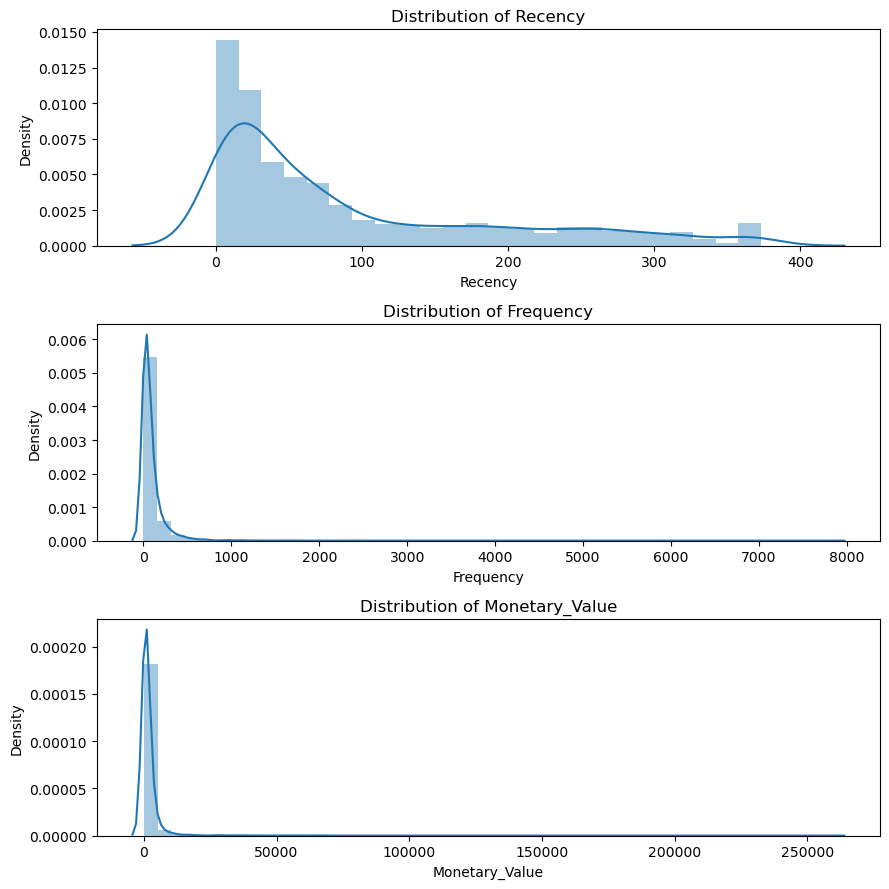

In [39]:
# Plot all 3 graphs together for summary findings
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(RFM_Table,'Recency')

plt.subplot(3, 1, 2)
check_skew(RFM_Table,'Frequency')

plt.subplot(3, 1, 3)
check_skew(RFM_Table,'Monetary_Value')

plt.tight_layout()
plt.savefig('before_transform.png', format='png', dpi=1000)

<b>The data is highly skewed,therefore we will perform log transformations to reduce the skewness of each variable.I add a small constant as log transformation demands all the values to be positive.</b>

In [40]:
df_rfm_log = RFM_Table.copy()

Recency's: Skew: -0.4635591539552193, : SkewtestResult(statistic=-11.314301280234206, pvalue=1.114869536941138e-29)
Frequency's: Skew: -0.02600696239989871, : SkewtestResult(statistic=-0.6659021000684195, pvalue=0.5054736781086501)
Monetary_Value's: Skew: 0.3694308288045071, : SkewtestResult(statistic=9.166088768517884, pvalue=4.904929990328552e-20)


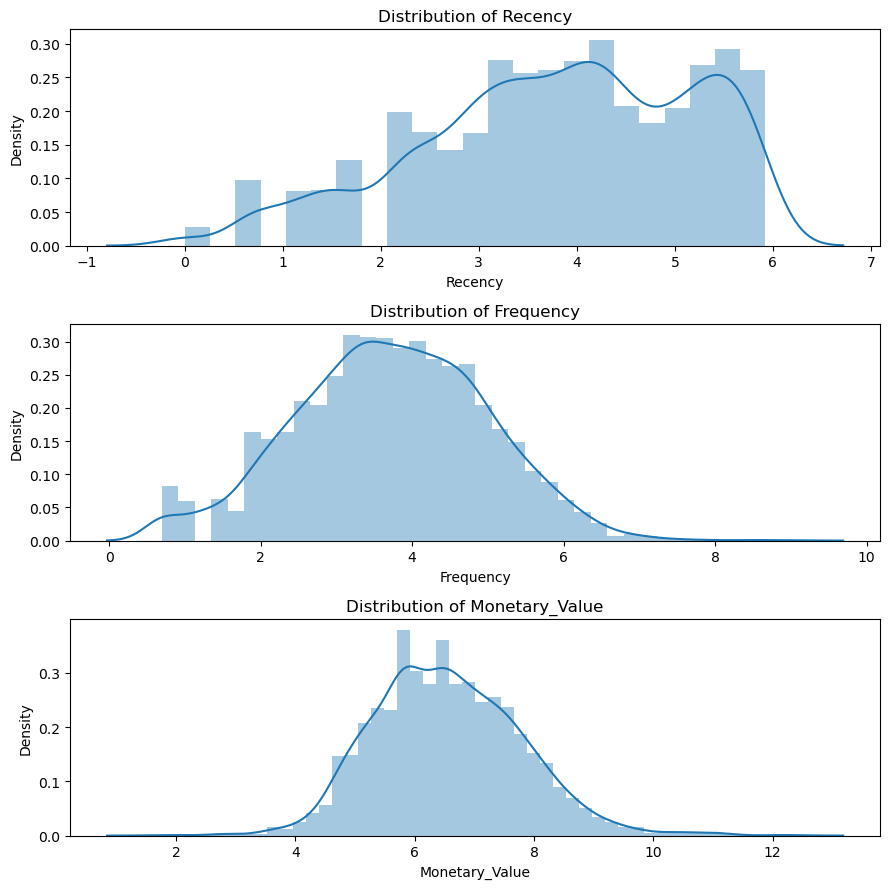

In [41]:
df_rfm_log = np.log(df_rfm_log+1)

plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(df_rfm_log,'Recency')

plt.subplot(3, 1, 2)
check_skew(df_rfm_log,'Frequency')

plt.subplot(3, 1, 3)
check_skew(df_rfm_log,'Monetary_Value')

plt.tight_layout()
plt.savefig('after_transform.png', format='png', dpi=1000)

In [42]:
RFM_Table.describe()

,CustomerID,Recency,Frequency,Monetary_Value
count,3920.000000,3920.000000,3920.000000,3920.000000
mean,15562.059694,91.742092,90.388010,1864.385601
std,1576.594671,99.533485,217.808385,7482.817477
min,12346.000000,0.000000,1.000000,3.750000
25%,14208.750000,17.000000,17.000000,300.280000
50%,15569.500000,50.000000,41.000000,652.280000
75%,16913.250000,142.000000,99.250000,1576.585000
max,18287.000000,373.000000,7847.000000,259657.300000


In [49]:
from feature_engine.outliers import Winsorizer

# Initialize Winsorizer without the 'distribution' argument
windsoriser = Winsorizer(capping_method='quantiles',  # Use 'quantiles' or 'iqr' or 'gaussian'
                         tail='both',                 # Cap left, right or both tails
                         fold=0.05,                   # Proportion of observations to cap
                         variables=['Recency', 'Frequency', 'Monetary_Value']
                        )

# Fit the Winsorizer
windsoriser.fit(df_rfm_log)

# Transform the data
df_rfm_log_winsorized = windsoriser.transform(df_rfm_log)


In [50]:
df_rfm_log = windsoriser.transform(df_rfm_log)

In [51]:
 scaler = StandardScaler()

scaler.fit(df_rfm_log)

RFM_Table_scaled = scaler.transform(df_rfm_log)

In [52]:
RFM_Table_scaled = pd.DataFrame(RFM_Table_scaled, columns=df_rfm_log.columns)

## K-Means Clustering

### Finding the optimal number of clusters

In [53]:
from scipy.spatial.distance import cdist
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(RFM_Table_scaled) 
    kmeanModel.fit(RFM_Table_scaled)     
      
    distortions.append(sum(np.min(cdist(RFM_Table_scaled, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / RFM_Table_scaled.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(RFM_Table_scaled, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / RFM_Table_scaled.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

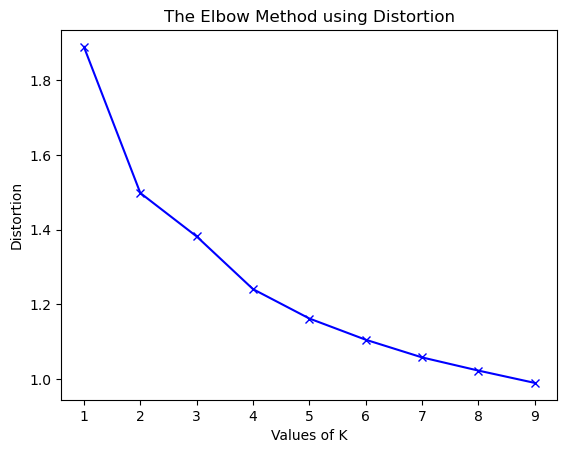

In [54]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

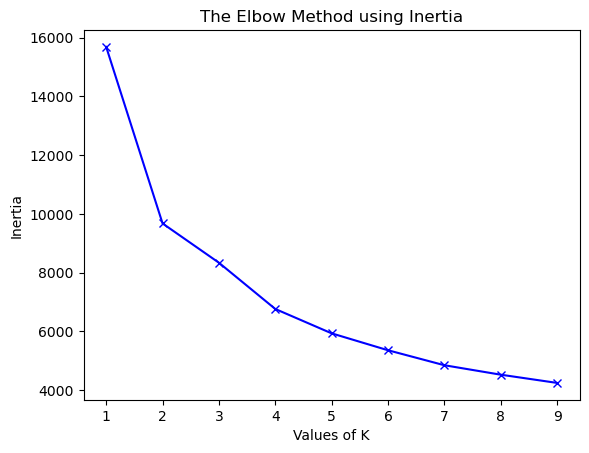

In [55]:

plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

<b>The cluster value where this decrease in inertia value becomes constant can be chosen as the right cluster value for our data. Looking at the above elbow curve, we can choose any number of clusters between 4 to 7.</b>

In [56]:
def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

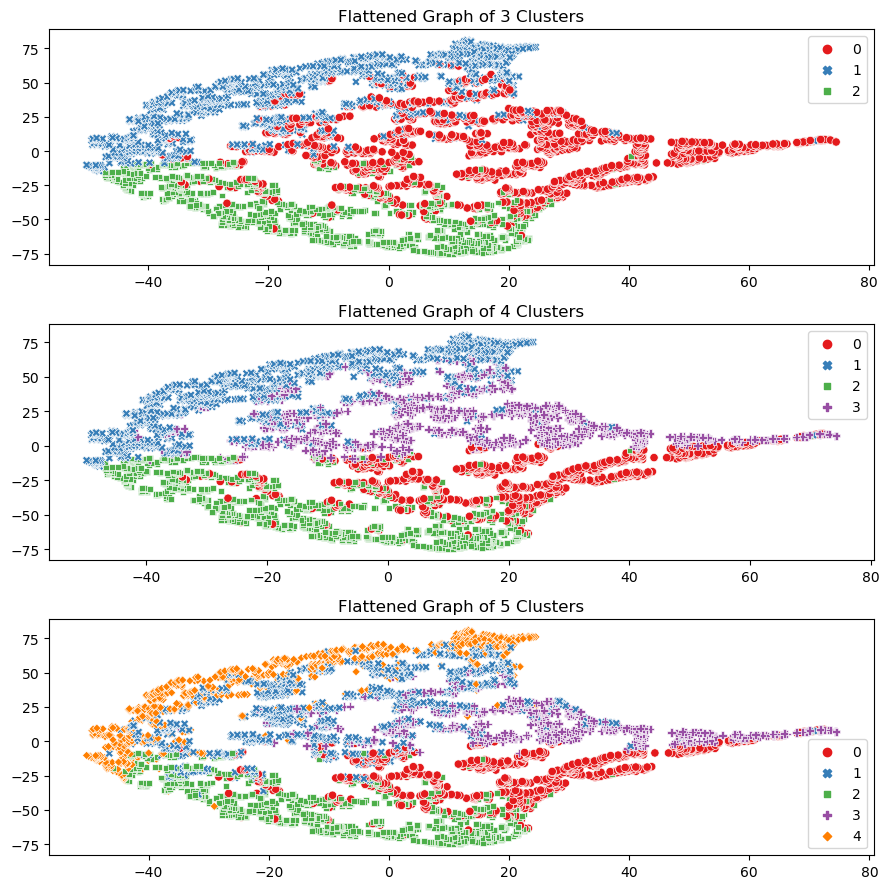

In [57]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
df_rfm_k3 = kmeans(RFM_Table_scaled, 3, RFM_Table)

plt.subplot(3, 1, 2)
df_rfm_k4 = kmeans(RFM_Table_scaled, 4, RFM_Table)

plt.subplot(3, 1, 3)
df_rfm_k5 = kmeans(RFM_Table_scaled, 5, RFM_Table)

plt.tight_layout()
plt.savefig('flattened.png', format='png', dpi=1000)

In [58]:

def snake_plot(normalised_df_rfm, df_rfm_kmeans, df_rfm_original):

    normalised_df_rfm = pd.DataFrame(normalised_df_rfm, 
                                       index=RFM_Table.index, 
                                       columns=RFM_Table.columns)
    normalised_df_rfm['Cluster'] = df_rfm_kmeans['Cluster']

    # Melt data into long format
    df_melt = pd.melt(normalised_df_rfm.reset_index(), 
                        id_vars=['CustomerID', 'Cluster'],
                        value_vars=['Recency', 'Frequency', 'Monetary_Value'], 
                        var_name='Metric', 
                        value_name='Value')

    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')
    
    return

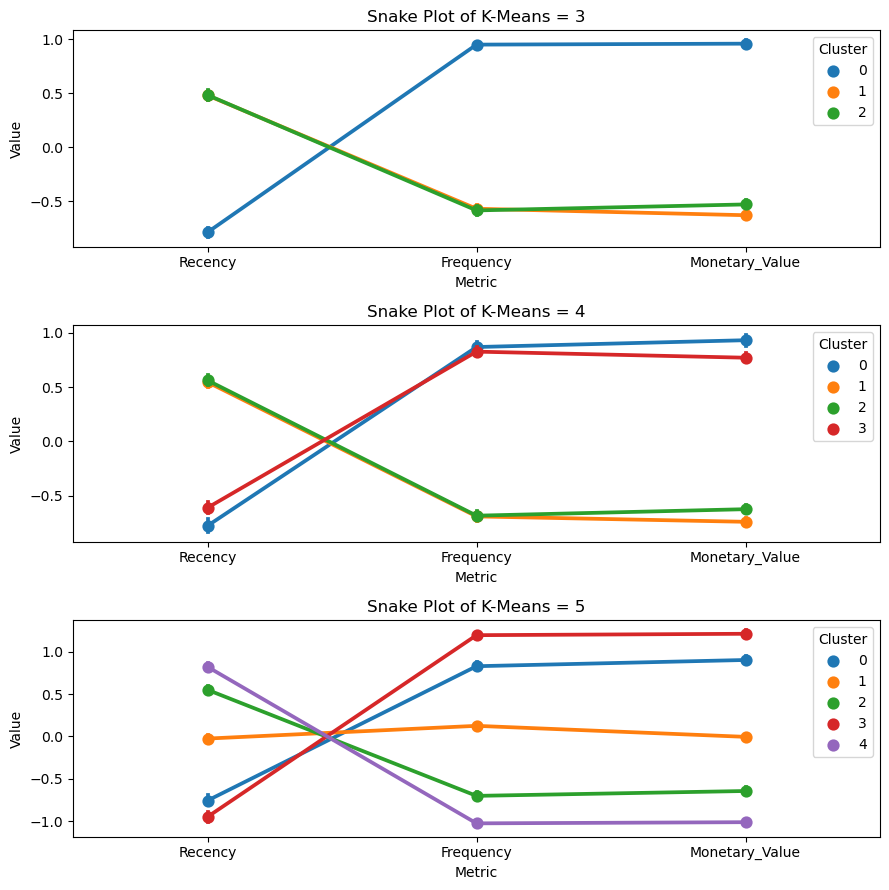

In [59]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
plt.title('Snake Plot of K-Means = 3')
snake_plot(RFM_Table_scaled, df_rfm_k3, RFM_Table)

plt.subplot(3, 1, 2)
plt.title('Snake Plot of K-Means = 4')
snake_plot(RFM_Table_scaled, df_rfm_k4, RFM_Table)

plt.subplot(3, 1, 3)
plt.title('Snake Plot of K-Means = 5')
snake_plot(RFM_Table_scaled, df_rfm_k5, RFM_Table)

plt.tight_layout()

<b>From the flattened graphs and the snake plots it is evident that having a cluster value of 4,segments our customers well. 
   We could also go for higher number of clusters, it completely depends on how the company wants to segment their customers.</b>

### Interpretation of the clusters formed using k-means .
 

In [60]:
def rfm_values(df):

    df_new = df.groupby(['Cluster']).agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary_Value': ['mean', 'count']
    }).round(0)
    
    return df_new

In [61]:
rfm_values(df_rfm_k4)

Recency Frequency Monetary_Value      
           mean      mean           mean count
Cluster                                       
0          28.0     186.0         3616.0   774
1         140.0      24.0          425.0  1125
2         141.0      24.0          553.0  1039
3          35.0     161.0         3520.0   982

## conclusion
- <b> The first cluster belongs to the "Best Customers" segment which we saw earlier as they purchase recently (R=1), frequent buyers (F=1), and spent the most (M=1).</b>
- <b>Customers in the second cluster can be interpreted as passerby customers as their last purchase is long ago (R=4),purchased very few (F=4) and spent little (M=4).Company has to come up with new strategies to make them permanent members.</b>   
- <b>The third cluster is more related to the "Almost Lost" segment as they Haven’t purchased for some time(R=3), but used to purchase frequently and spent a lot.</b>
- <b>The last cluster are very Loyal Customers and they also spent a lot. </b>